In [0]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

--2019-11-14 09:13:42--  https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88706549 (85M) [application/octet-stream]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[===================>]  84.60M   157MB/s    in 0.5s    

2019-11-14 09:13:48 (157 MB/s) - ‘/tmp/julia.tar.gz’ saved [88706549/88706549]

   Cloning default registries into /root/.julia/registries
   Cloning registry General from "https://github.com/JuliaRegistries/General.git"
 Resolving package versions...
 Installed VersionParsing ── v1.1.3
 Installed Conda ─────────── v1.3.0
 Installed Parsers ───────── v0.3.8
 Installed ZMQ ───────────── v1.0.0
 Installed JSON ──────────── v0.21.0
 Installed BinaryProvider ─

In [0]:
using Pkg

pkg"add CuArrays"
pkg"add Flux"
pkg"add ImageMagick"
pkg"add Images"
pkg"add Plots"

pkg"precompile"

using Base.Iterators: repeated

using CuArrays
using Flux
using Flux: onehotbatch, onecold, crossentropy, throttle
using Flux.Data.MNIST
using Images
using Plots

using LinearAlgebra
using Random
using Statistics

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
Precompiling project...


# The SoftMax, activation functions, and Regularisation #

This lecture is a collection of important concepts, yet they are too quickly covered to warrant a lecture on their own.

## The SoftMax ###

So far, we have – sometimes somewhat forcefully – cast all our learning problems as binary classification problems. At this point in time it is time to consider multi-class classification problems. Although we have previously mentioned the idea of one-vs-all classification, surely there must be something more elegant than training a number of classifiers equal to your number of classes?

### The logistic function ###

Allow us to recall the logistic function, why did we consider it convenient again?

$$ σ(x)  = \frac{1}{1 + e^{-x}} $$

$$ σ′(x) = σ(x)(1 - σ(x)) $$

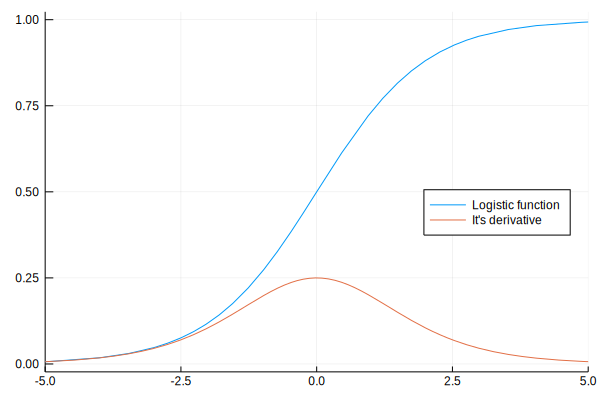

In [0]:
logistic(x)      = 1/(1 .+ exp.(-x))
logisticprime(x) = logistic(x).*(1 .- logistic(x))

plt = plot(logistic, xlim=(-5, 5), label="Logistic function")
plot!(plt, logisticprime, xlim=(-5, 5), label="It's derivative", legend=:right)

$$ σ : \mathbb{R} \to [0, 1] $$

$$ σ(0) = 0.5 $$

So far, we have seen the following, assuming that $\textbf{x} \in \mathbb{R}^{17}$ and $y \in \{0, 1\}$.

In [0]:
x = randn(17)
W = randn(1, 17)

W*x

1-element Array{Float64,1}:
 -4.184845564175983

We then apply the logistic function so that we can interpret the output as a probability. 

In [0]:
logistic(W*x)

1×1 LinearAlgebra.Transpose{Float64,Array{Float64,1}}:
 0.014996245779060958

However, this clearly will not work for the multi-class case, where for example $y \in \{0, \ldots, 9\}$.

logistic.(W * x) = [0.00528142, 0.844568, 0.16859, 0.00376713, 0.0663337, 0.0162458, 0.967336, 0.979473, 0.00210134, 0.708398]
sum(logistic.(W * x)) = 3.7620948112028123


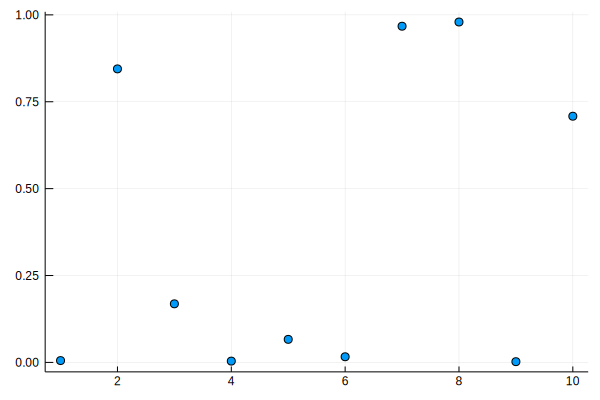

In [0]:
x = randn(17)
W = randn(10, 17)

@show logistic.(W*x) sum(logistic.(W*x))
scatter(logistic.(W*x), legend=:none)

Not even if we squint will this look like a probability distribution…

### The SoftMax function ###

In its vectorised form, for $n$ classes:

$$ f(\textbf{x}) = [\frac{e^{x_1}}{\sum_{i=1}^{n} e^{x_i}}, \ldots, \frac{e^{x_n}}{\sum_{i=1}^{n} e^{x_i}}] $$

softmax(W * x) = [6.21019e-5, 0.0635547, 0.00237177, 4.42286e-5, 0.000830991, 0.000193156, 0.346385, 0.558119, 2.463e-5, 0.0284146]
sum(softmax(W * x)) = 0.9999999999999999


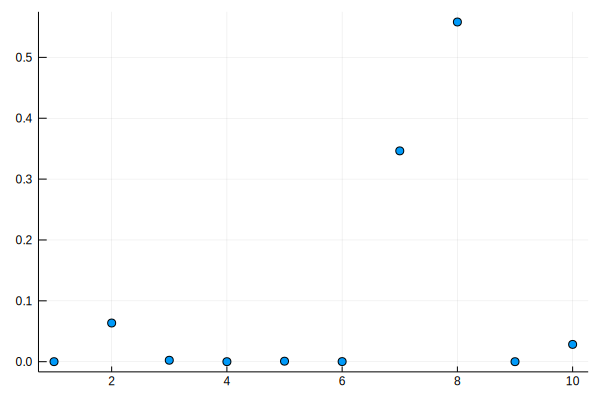

In [0]:
@show softmax(W*x) sum(softmax(W*x))
scatter(softmax(W*x), legend=:none)

W * x = [-5.23826, 1.69262, -1.59565, -5.57767, -2.64442, -4.10354, 3.38827, 3.86529, -6.16308, 0.887617]
logistic.(W * x) = [0.00528142, 0.844568, 0.16859, 0.00376713, 0.0663337, 0.0162458, 0.967336, 0.979473, 0.00210134, 0.708398]
softmax(W * x) = [6.21019e-5, 0.0635547, 0.00237177, 4.42286e-5, 0.000830991, 0.000193156, 0.346385, 0.558119, 2.463e-5, 0.0284146]
abs.(logistic.(W * x) .- softmax(W * x)) = [0.00521932, 0.781013, 0.166219, 0.0037229, 0.0655027, 0.0160527, 0.620951, 0.421354, 0.00207671, 0.679984]


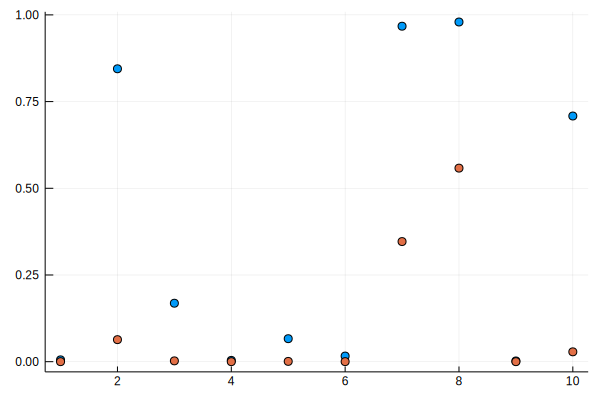

In [0]:
@show W*x logistic.(W*x) softmax(W*x) abs.(logistic.(W*x) .- softmax(W*x))
plt = scatter(logistic.(W*x), legend=:none)
scatter!(plt, softmax(W*x), legend=:none)

Hopefully (if there was at least one outlier in our random initialisation) you can clearly see above how the softmax “squeezes” the non-outliers towards zero by the virtue of the exponentiation. At times I find it helpful to think of this as a sort of function smoothing.

### Binary cross-entropy ###

$$ J(\textbf{y}, \hat{\textbf{y}}) = - \sum_{i=1}^{n} \textbf{y}_{i} \textrm{log}(\hat{\textbf{y}}_{i})  $$

Calculating the gradients for the softmax given a cross-entropy loss is surprisingly hairy, but you end up with a very nice expression by virtue of the interplay between the two functions:

$$ \frac{\partial J}{\partial W_{j, i}} = \textbf{h}_{j}(\hat{\textbf{y}}_{i} - \textbf{y}_{i}) $$

Where $\textbf{h}$ is the input to the softmax function.

This expression feels somewhat familiar…

One somewhat counterintuitive effect of the softmax is that we get “weak” interactions between each class – or another way to look at it, the gradients of each row in $W$ than can conceptually be seen as separate classifiers. Why does this occur?

## Multi-class classification on MNIST using a multi-layer perceptron ##

In [0]:
function load(set; sub=1)
    images = MNIST.images(set)[1:div(end, sub)]
    labels = MNIST.labels(set)[1:div(end, sub)]
    # Brownie points, what do you think this does…?
    xs = hcat(float.(reshape.(images, :))...) |> gpu
    ys = onehotbatch(labels, 0:9) |> gpu
    (images, labels, xs, ys)
end

trainimages, trainlabels, trainxs, trainys = load(:train, sub=200)
@show size(trainxs) trainxs[:, 1] size(trainys) trainys[:, 1]
validimages, validlabels, validxs, validys = load(:valid, sub=200)
testimages, testlabels, testxs, testys = load(:test, sub=200)

nothing

size(trainxs) = (784, 300)
trainxs[:, 1] = Gray{Float32}[Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gra

Let us have a look at a few samples.

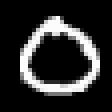

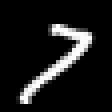

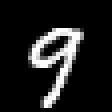

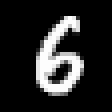

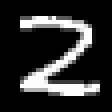

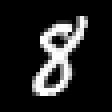

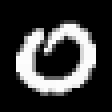

In [0]:
for _ in 1:7
    display(trainimages[rand(1:end)])
end

In [0]:
model        = Chain(
    Dense(28^2, 64, logistic),
    Dense(64, 10),
    softmax,
    ) |> gpu
loss(x, y)   = crossentropy(model(x), y)
epochs       = 5_000
trainingdata = repeated((trainxs, trainys), epochs)
callback     = () -> println("$(loss(trainxs, trainys))\t$(loss(validxs, validys))\t$(loss(testxs, testys))")
optimiser    = ADAM()

@time Flux.train!(loss, params(model), trainingdata, optimiser, cb=throttle(callback, 1))
callback()

nothing

2.5292308f0 (tracked)	2.531533f0 (tracked)	2.531533f0 (tracked)
2.1573033f0 (tracked)	2.132936f0 (tracked)	2.132936f0 (tracked)
1.9806165f0 (tracked)	1.9921452f0 (tracked)	1.9921452f0 (tracked)
1.806696f0 (tracked)	1.861187f0 (tracked)	1.861187f0 (tracked)
1.6471364f0 (tracked)	1.7472897f0 (tracked)	1.7472897f0 (tracked)
1.5042961f0 (tracked)	1.6496396f0 (tracked)	1.6496396f0 (tracked)
1.3806242f0 (tracked)	1.5672601f0 (tracked)	1.5672601f0 (tracked)
1.2706707f0 (tracked)	1.4947081f0 (tracked)	1.4947081f0 (tracked)
1.1755046f0 (tracked)	1.4317197f0 (tracked)	1.4317197f0 (tracked)
1.093388f0 (tracked)	1.3767438f0 (tracked)	1.3767438f0 (tracked)
1.0203995f0 (tracked)	1.3270806f0 (tracked)	1.3270806f0 (tracked)
0.9564432f0 (tracked)	1.2827705f0 (tracked)	1.2827705f0 (tracked)
0.89965814f0 (tracked)	1.2427442f0 (tracked)	1.2427442f0 (tracked)
0.84857875f0 (tracked)	1.2062107f0 (tracked)	1.2062107f0 (tracked)
0.80232716f0 (tracked)	1.1727862f0 (tracked)	1.1727862f0 (tracked)
0.761176f0 (tra

### Issues with the SoftMax ###

Perhaps somewhat counterintuitively, the SoftMax is frequently the most computatianlly expensive operation inside a neural network. This has lead to plenty of research on alternatives.

#### Hierarchical SoftMax ###

![](https://ruder.io/content/images/2016/05/hierarchical_softmax.png)

[Image source](http://ruder.io/word-embeddings-softmax/)

Key problem, how do we construct the hierarchy? Any guesses how?

#### There is more… ####

* Negative sampling (a'la word2vec)
* Blackout
* And more!

## Activation functions ##

### Logistic ###

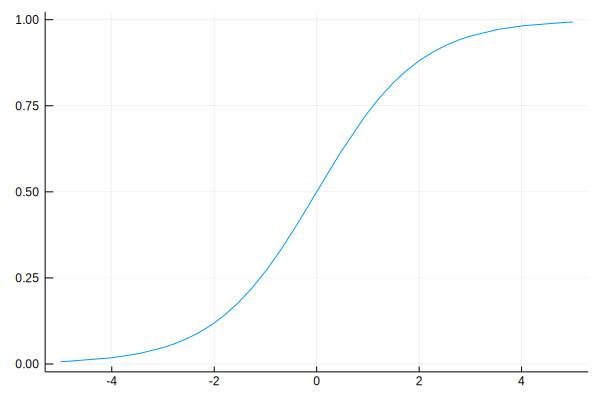

In [0]:
plot(logistic, legend=:none)

### Hyperbolic tangent ###

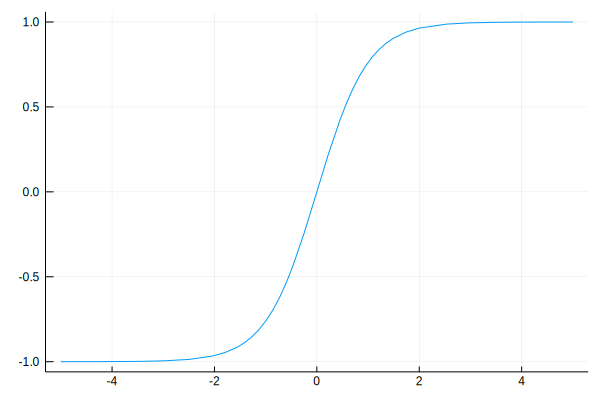

In [0]:
plot(tanh, legend=:none)

### Rectifier ###

In conjunction with a linear projection layer, its output is commonly referred to as a rectified linear unit (ReLU) – you will see this a lot.

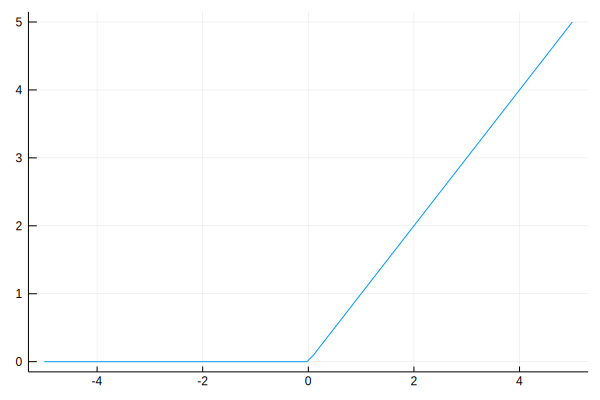

In [0]:
rectifier(x) = max(0, x)

plot(rectifier, legend=:none)

### Softplus ###

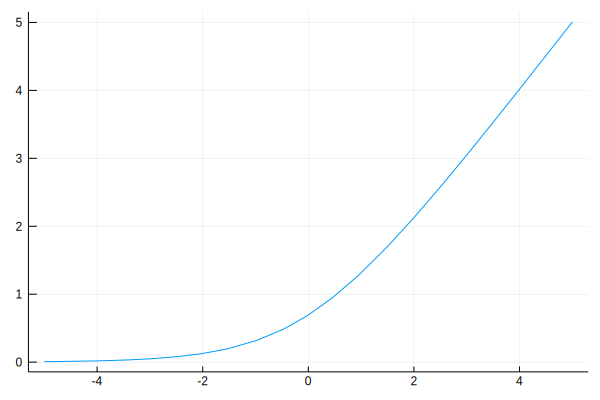

In [0]:
softplus(x) = log(1 + exp(x))

plot(softplus, legend=:none)

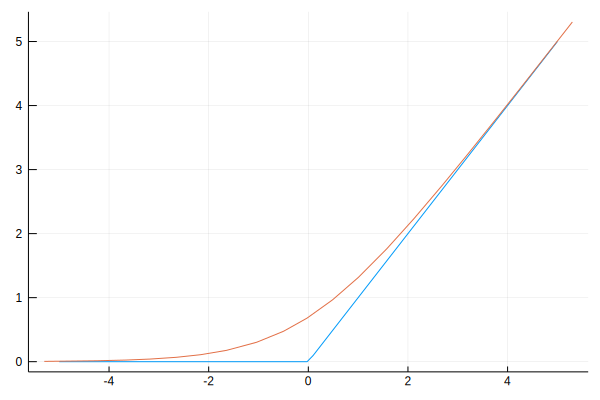

In [0]:
plt = plot(rectifier, legend=:none)
plot!(plt, softplus, legend=:none)

### Leaky rectifier ###

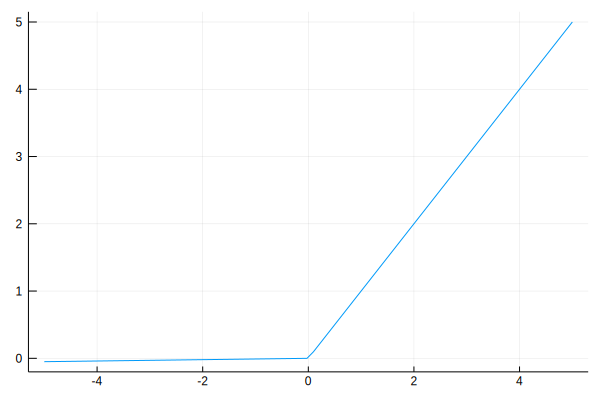

In [0]:
leakyrectifier(x) = max(0.01x, x)

plot(leakyrectifier, legend=:none)

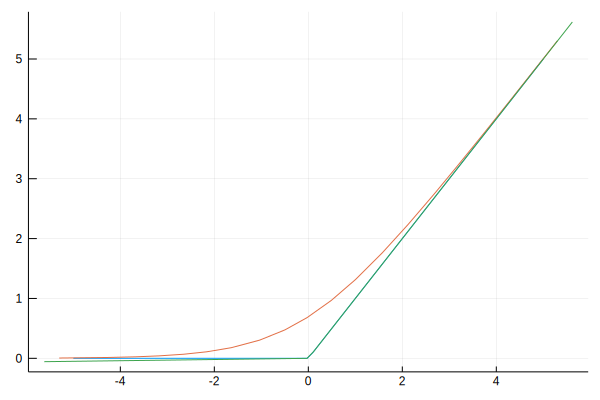

In [0]:
plt = plot(rectifier, legend=:none)
plot!(plt, softplus, legend=:none)
plot!(plt, leakyrectifier, legend=:none)

In practice, the logistic function is a “safe bet”. The hyperbolic tangent is only really seen in recurrent neural networks (more on this next week) and rectifiers dominate computer vision and has started to take over portions of other fields as well.

## Regularisation ##

XXX:

### $L^2$ norm ###

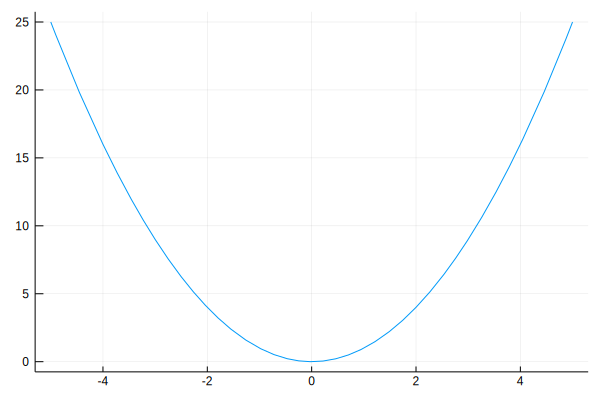

In [0]:
plot(x -> x^2, legend=:none)

### $L^1$ norm ###

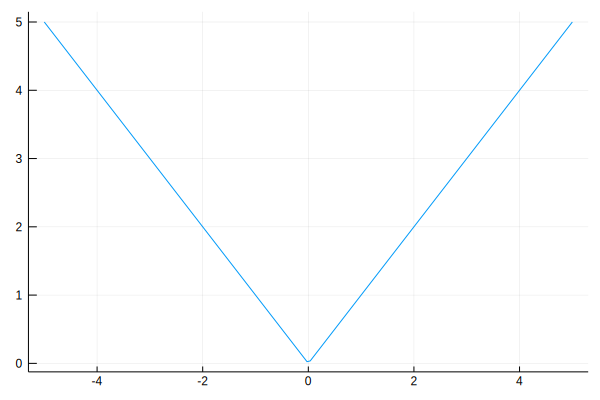

In [0]:
plot(x -> abs(x), legend=:none)

In [0]:
model        = Chain(
    Dense(28^2, 64, logistic),
    Dense(64, 10),
    softmax,
    ) |> gpu
# Note the change here.
lambda       = 0.001
loss(x, y)   = crossentropy(model(x), y) + lambda*sum(norm, params(model))
epochs       = 5_000
trainingdata = repeated((trainxs, trainys), epochs)
callback     = () -> println("$(loss(trainxs, trainys))\t$(loss(validxs, validys))\t$(loss(testxs, testys))")
optimiser    = ADAM()

@time Flux.train!(loss, params(model), trainingdata, optimiser, cb=throttle(callback, 1))
callback()

nothing

┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(exp(x::T) where T<:Union{Float32, Float64} in Base.Math at special/exp.jl:75, exp(x::Float32) in CUDAnative at /root/.julia/packages/CUDAnative/3Jwj2/src/device/cuda/math.jl:99), Base.StackTraces.StackFrame[exp at exp.jl:75, #25 at broadcast.jl:49])
└ @ CUDAnative /root/.julia/packages/CUDAnative/3Jwj2/src/compiler/irgen.jl:116


2.5783359642028807 (tracked)	2.643615686416626 (tracked)	2.643615686416626 (tracked)
2.2932168068885805 (tracked)	2.254148584842682 (tracked)	2.254148584842682 (tracked)
2.292602120876312 (tracked)	2.256816445827484 (tracked)	2.256816445827484 (tracked)
2.2925507473945617 (tracked)	2.2566546845436095 (tracked)	2.2566546845436095 (tracked)
2.292465467453003 (tracked)	2.2565896701812744 (tracked)	2.2565896701812744 (tracked)
2.2923720121383666 (tracked)	2.2564950227737426 (tracked)	2.2564950227737426 (tracked)
2.29227773475647 (tracked)	2.256372611999512 (tracked)	2.256372611999512 (tracked)
2.292209638595581 (tracked)	2.2563014163970947 (tracked)	2.2563014163970947 (tracked)
2.2921254827976227 (tracked)	2.2561917498111725 (tracked)	2.2561917498111725 (tracked)
2.2920825109481813 (tracked)	2.2561173067092897 (tracked)	2.2561173067092897 (tracked)
2.291999766111374 (tracked)	2.2560400454998017 (tracked)	2.2560400454998017 (tracked)
2.2919492421150207 (tracked)	2.255974501132965 (tracked)	

What is it that these two norms achieve? Also, yes, we now have **another** hyperparameter.

### Early stopping ###

Halt optimisation prior to convergence, given some heuristic. Commonly that heuristic is when performance start decreasing on the validation set.

### Dropout ###

Disable hidden layer activations randomly during training, commonly with a probability of 0.5 per activation. Then scale each activation at *test time* relative to the dropout probability.

![](https://opendatascience.com/wp-content/uploads/2017/04/dropout-nn.jpg)

[Image source](https://opendatascience.com/blog/dropout-with-theano/)

Why is there any reason to believe that this helps a model generalise?